In [19]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
import mahotas
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
 dataset_path = r'C:\Users\shash\Downloads\apple'
 img_size = (64, 64)

In [3]:
X = []
y = []
labels = os.listdir(dataset_path)

In [4]:
for label in labels:
    folder_path = os.path.join(dataset_path, label)
    if not os.path.isdir(folder_path):
        continue

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, img_size)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys',
                          visualize=True)

        moments = cv2.moments(gray)
        hu_moments = cv2.HuMoments(moments).flatten()

        haralick_features = mahotas.features.haralick(gray).mean(axis=0)

        hist_r = cv2.calcHist([img], [0], None, [256], [0, 256])
        hist_g = cv2.calcHist([img], [1], None, [256], [0, 256])
        hist_b = cv2.calcHist([img], [2], None, [256], [0, 256])
        color_hist = np.concatenate([hist_r.flatten(), hist_g.flatten(), hist_b.flatten()])

        combined_features = np.concatenate([features, hu_moments, haralick_features, color_hist])

        X.append(combined_features)
        y.append(label)

print(f"Total samples: {len(X)}") 


Total samples: 7771


In [5]:
labels = os.listdir(dataset_path)
print("Labels:", labels)

Labels: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


In [6]:
X = np.array(X)
y = np.array(y)

In [7]:
print("Shape of X:", X.shape)

Shape of X: (7771, 2552)


In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
pca = PCA(n_components=0.95)  
X_pca = pca.fit_transform(X_scaled)
print(f"Shape after PCA: {X_pca.shape}")

Shape after PCA: (7771, 583)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)  
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
y_pred = rf.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Combined Features + RF Accuracy + pca: {accuracy * 100:.2f}%')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Combined Features + RF Accuracy + pca: 83.34%

Classification Report:
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.85      0.71      0.77       427
       Apple___Black_rot       0.78      0.94      0.85       361
Apple___Cedar_apple_rust       0.89      0.84      0.87       359
         Apple___healthy       0.83      0.86      0.85       408

                accuracy                           0.83      1555
               macro avg       0.84      0.84      0.83      1555
            weighted avg       0.84      0.83      0.83      1555



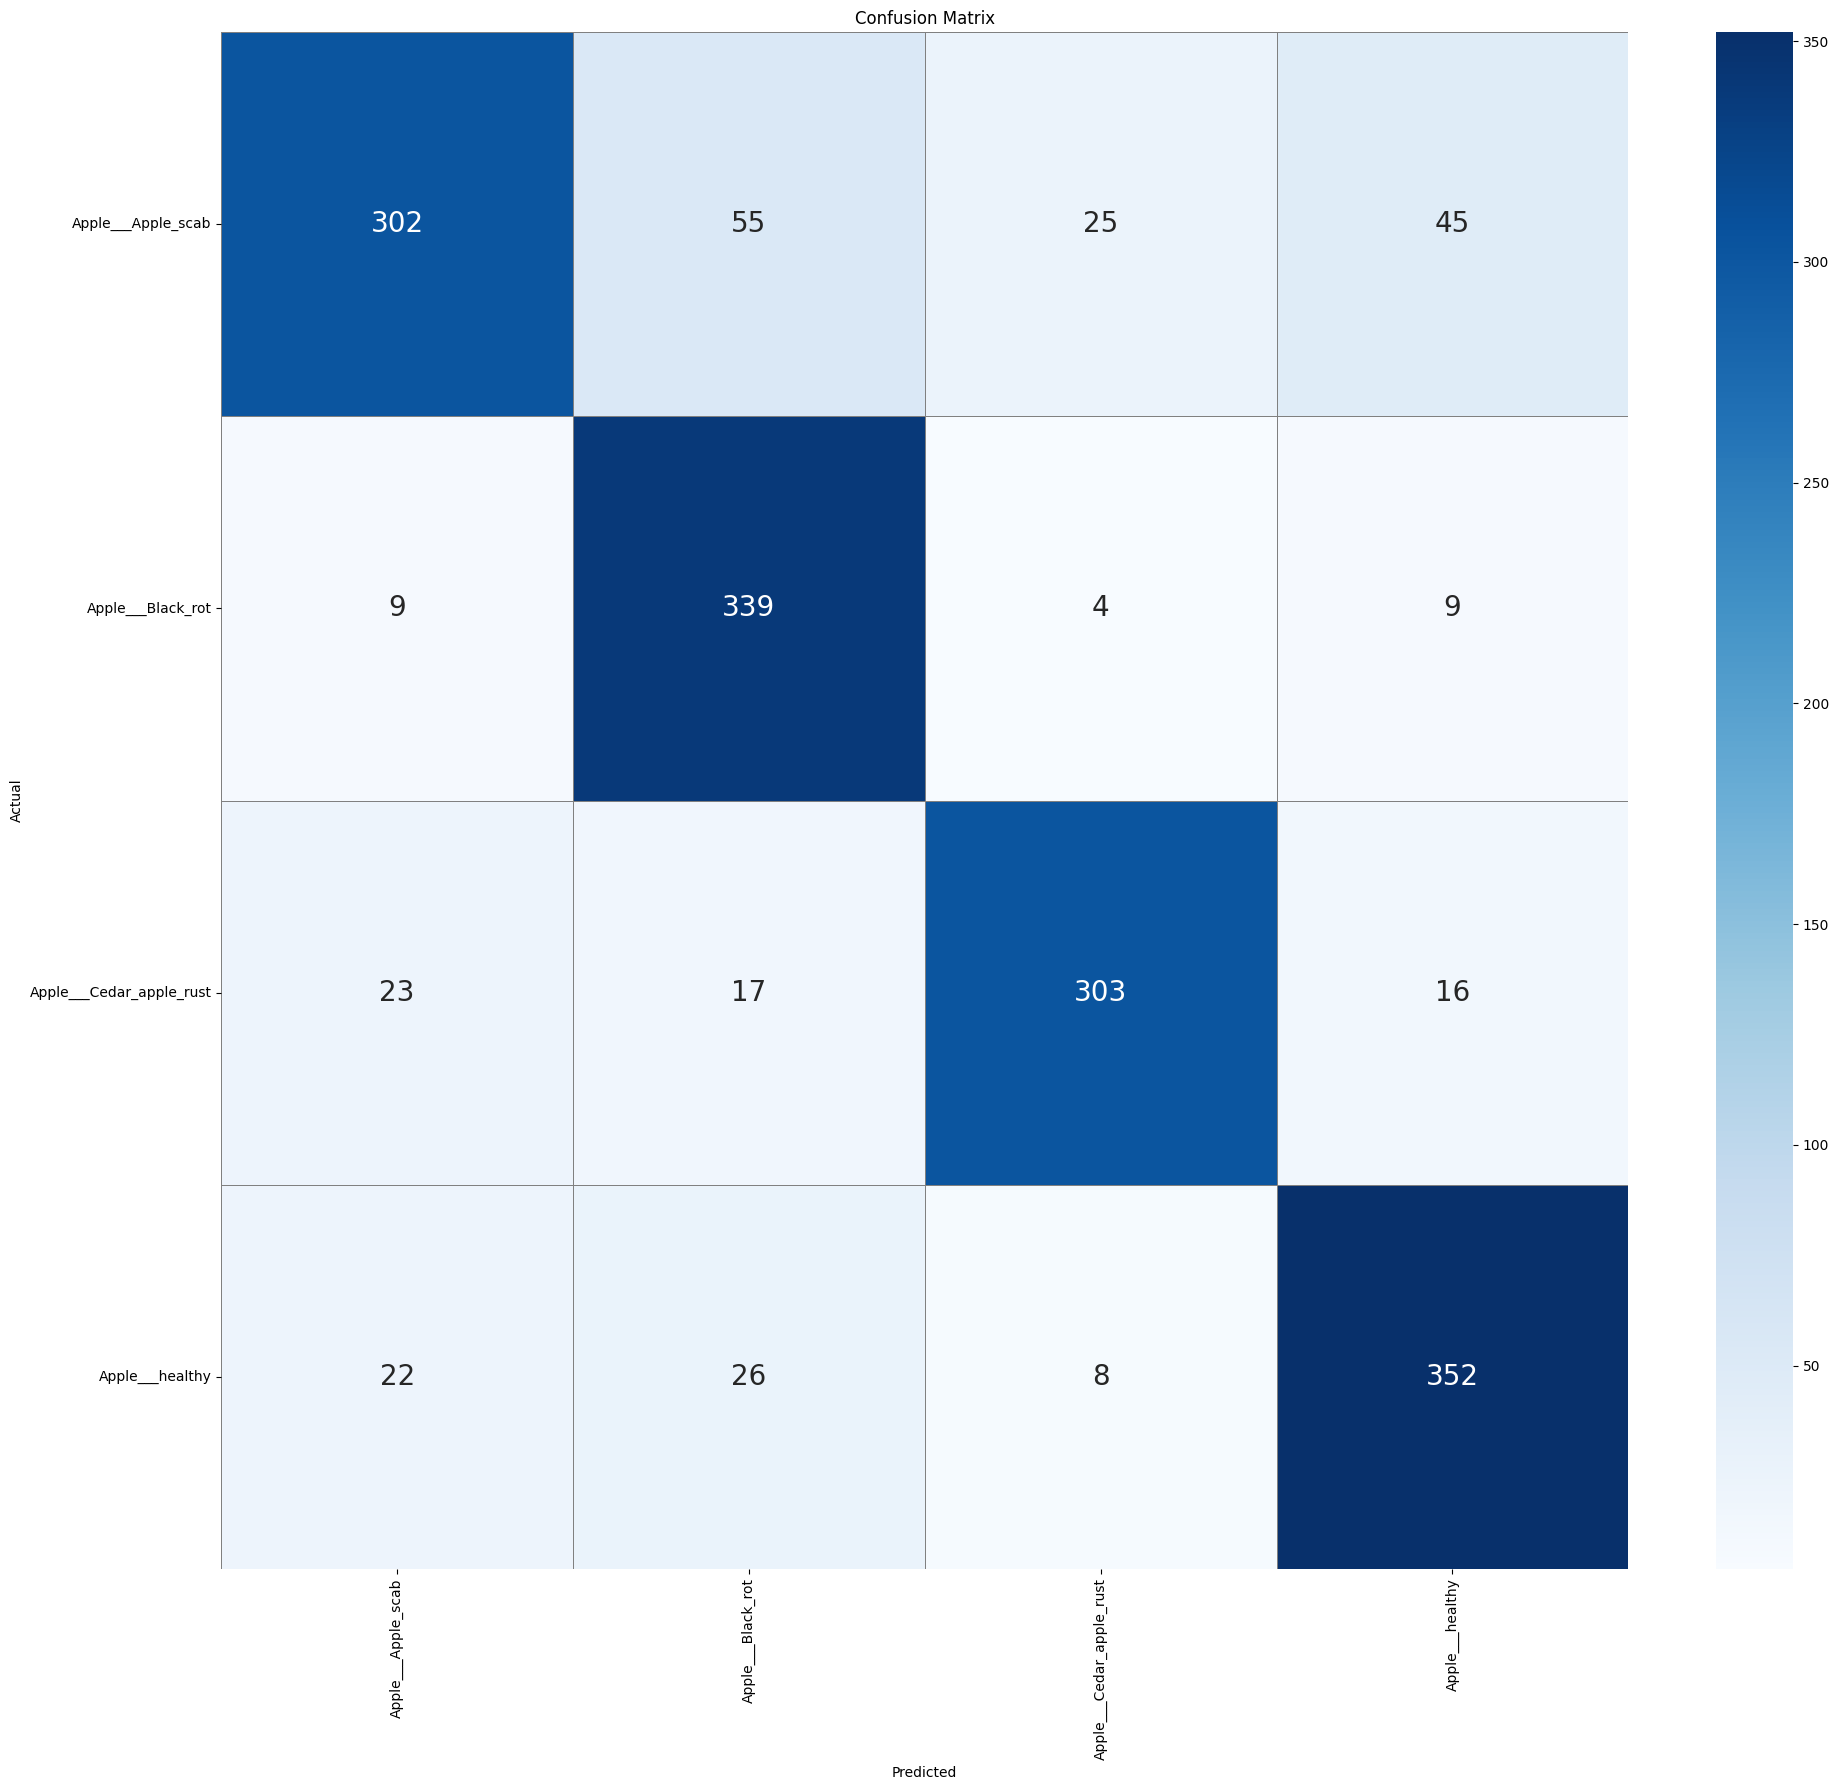

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=0.5, linecolor='gray', annot_kws={"size": 20})

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_rf_pca.png', dpi=300, bbox_inches='tight')

plt.show()


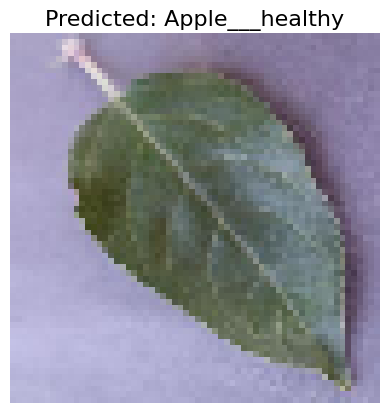

In [18]:
test_img_path = r'C:\Users\shash\Downloads\apple\Apple___healthy\ff89a869-8eb9-4a0a-9132-dc63e94421bd___RS_HL 7649_flipTB.JPG'

if not os.path.exists(test_img_path):
    print("File does not exist. Exiting.")
    exit()

img = cv2.imread(test_img_path)
if img is None:
    print("Failed to read image. Exiting.")
    exit()

img_size = (64, 64)
img_resized = cv2.resize(img, img_size)
gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2), block_norm='L2-Hys',
                  visualize=True)

moments = cv2.moments(gray)
hu_moments = cv2.HuMoments(moments).flatten()

haralick_features = mahotas.features.haralick(gray).mean(axis=0)

hist_r = cv2.calcHist([img_resized], [0], None, [256], [0, 256])
hist_g = cv2.calcHist([img_resized], [1], None, [256], [0, 256])
hist_b = cv2.calcHist([img_resized], [2], None, [256], [0, 256])
color_hist = np.concatenate([hist_r.flatten(), hist_g.flatten(), hist_b.flatten()])

combined_features = np.concatenate([features, hu_moments, haralick_features, color_hist])

combined_features_scaled = scaler.transform([combined_features])
combined_features_pca = pca.transform(combined_features_scaled)

prediction = rf.predict(combined_features_pca)
predicted_label = prediction[0]

plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {predicted_label}", fontsize=16)
plt.axis('off')
plt.show()